In [1]:
%matplotlib inline

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

lib_path = os.path.join('../src/lib')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
lib_path = os.path.join('../src/')
if not lib_path in sys.path:
    sys.path.append(lib_path)
    
import json
import cv2
from glob import glob
import numpy as np
import time
from progress.bar import Bar
import torch

from external.nms import soft_nms
from jupyter_opts import opts
from logger import Logger
from utils.utils import AverageMeter
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory

In [3]:
class PrefetchDataset(torch.utils.data.Dataset):
  def __init__(self, opt, dataset, pre_process_func):
    self.images = dataset.images
    self.load_image_func = dataset.coco.loadImgs
    self.img_dir = dataset.img_dir
    self.pre_process_func = pre_process_func
    self.opt = opt
  
  def __getitem__(self, index):
    img_id = self.images[index]
    img_info = self.load_image_func(ids=[img_id])[0]
    img_path = os.path.join(self.img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    images, meta = {}, {}
    for scale in opt.test_scales:
      if opt.task == 'ddd':
        images[scale], meta[scale] = self.pre_process_func(
          image, scale, img_info['calib'])
      else:
        images[scale], meta[scale] = self.pre_process_func(image, scale)
    return img_id, {'images': images, 'image': image, 'meta': meta}

  def __len__(self):
    return len(self.images)

def prefetch_test(opt):
  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str

  Dataset = dataset_factory[opt.dataset]
  opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
  print(opt)
  Logger(opt)
  Detector = detector_factory[opt.task]
  
  split = 'val' if not opt.trainval else 'test'
  dataset = Dataset(opt, split)
  detector = Detector(opt)
  
  data_loader = torch.utils.data.DataLoader(
    PrefetchDataset(opt, dataset, detector.pre_process), 
    batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

  results = {}
  num_iters = len(dataset)
  bar = Bar('{}'.format(opt.exp_id), max=num_iters)
  time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
  avg_time_stats = {t: AverageMeter() for t in time_stats}
  for ind, (img_id, pre_processed_images) in enumerate(data_loader):
    ret = detector.run(pre_processed_images)
    results[img_id.numpy().astype(np.int32)[0]] = ret['results']
    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(
                   ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
      avg_time_stats[t].update(ret[t])
      Bar.suffix = Bar.suffix + '|{} {tm.val:.3f}s ({tm.avg:.3f}s) '.format(
        t, tm = avg_time_stats[t])
    bar.next()
  bar.finish()
  dataset.run_eval(results, opt.save_dir)

In [4]:
args = ['eldet']
opt = opts().parse(args)
opt.data_dir = '/data/cc/Data/CHD/detection/'
opt.load_model = '/data/cc/workspace/Repository/CenterNet/exp/eldet/det_fhd_dla/model_best.pth'
opt.num_classes = 2
opt.dataset = 'coco_fhd'
opt.resume = True

torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = dataset_factory[opt.dataset]
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default
heads {'hm': 2, 'wh': 2, 'reg': 2}
Namespace(K=2, aggr_weight=0.0, agnostic_ex=False, arch='dla_34', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/cc/Data/CHD/detection/', dataset='coco_fhd', debug=0, debug_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet/default/debug', debugger_theme='white', demo='', dense_hp=False, dense_wh=False, dep_weight=1, dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/cc/workspace/Repository/CenterNet/scripts/../../exp/eldet', exp_id='default', fix_res=True, flip=0.5, flip_test=False, gpus=[0], gpus_str='0', head_conv=256, heads={'hm': 2, 'wh': 2, 'reg': 2}, hide_data_ti

In [5]:
Detector = detector_factory[opt.task]

In [6]:
split = 'val'
opt.mean = [0, 0, 0]
opt.std = [1, 1, 1]
dataset = Dataset(opt, split)
detector = Detector(opt)

==> initializing Fetal Heart Disease val data.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loaded val 100 samples
Creating model...
loaded /data/cc/workspace/Repository/CenterNet/exp/eldet/det_fhd_dla/model_best.pth, epoch 35


In [7]:
results = {}
num_iters = len(dataset)
bar = Bar('{}'.format(opt.exp_id), max=num_iters)
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']
avg_time_stats = {t: AverageMeter() for t in time_stats}
for ind in range(num_iters):
    img_id = dataset.images[ind]
    img_info = dataset.coco.loadImgs(ids=[img_id])[0]
    img_path = os.path.join(dataset.img_dir, img_info['file_name'])

    if opt.task == 'ddd':
        ret = detector.run(img_path, img_info['calib'])
    else:
        ret = detector.run(img_path)

    results[img_id] = ret['results']

    Bar.suffix = '[{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(ind, num_iters, total=bar.elapsed_td, eta=bar.eta_td)
    for t in avg_time_stats:
        avg_time_stats[t].update(ret[t])
        Bar.suffix = Bar.suffix + '|{} {:.3f} '.format(t, avg_time_stats[t].avg)
    bar.next()
bar.finish()
dataset.run_eval(results, opt.save_dir)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

In [9]:
results

{2020000001: {1: array([[159.93593  ,  13.012911 , 521.84955  , 518.1785   ,   0.6277872]],
        dtype=float32),
  2: array([[339.7401    ,  88.40625   , 264.63367   , 263.41473   ,
            0.75094587]], dtype=float32)},
 2020000002: {1: array([[6.4932045e+01, 6.0982059e+01, 4.9296970e+02, 5.3882788e+02,
          3.6053401e-01]], dtype=float32),
  2: array([[196.24919   , 118.18561   , 315.84515   , 313.00912   ,
            0.42437977]], dtype=float32)},
 2020000003: {1: array([[171.15425   ,  33.84962   , 382.159     , 371.6356    ,
            0.65444416]], dtype=float32),
  2: array([[216.12878   ,  71.63046   , 222.0914    , 215.59354   ,
            0.72222066]], dtype=float32)},
 2020000004: {1: array([[206.42368  , 152.3943   , 411.25424  , 398.34088  ,   0.7398052]],
        dtype=float32),
  2: array([[381.82773  , 245.10501  , 212.1099   , 210.93481  ,   0.6912946]],
        dtype=float32)},
 2020000005: {1: array([[364.5981   , 114.81804  , 382.02243  , 366.885    ,

In [11]:
print(img_id)
img_info = dataset.coco.loadImgs(ids=[img_id])[0]

2020000374


# Inference

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

In [60]:
test_image_folder = '/data/cc/Data/CHD/detection/images/'
image_lists = sorted(glob(os.path.join(test_image_folder, "*.png")))
save_folder = '/data/cc/Data/CHD/detection/predictions/'

In [84]:
idx = 0
for img_path in image_lists:
    
    idx += 1
    
    img_name = img_path.split('/')[-1]
    ret = detector.run(img_path)
    
    lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
    lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
    heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
    heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))
    
    image = np.array(Image.open(img_path).convert('RGB'))
    img = cv2.rectangle(img=image, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
    img = cv2.rectangle(img=img, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
    
    result = Image.fromarray(img)
    result.save(os.path.join(save_folder, img_name))
    
    print("Processing img: {}, shape:{}, Lung pt1:{} pt2:{}, Heart pt1:{}, pt2:{}".format(img_name, image.shape, lung_pt1, lung_pt2, heart_pt1, heart_pt2))
    
#     if idx > 1:
#         break


Processing img: abnormal_0000.png, shape:(563, 822, 3), Lung pt1:(159, 13) pt2:(681, 531), Heart pt1:(339, 88), pt2:(604, 351)
Processing img: abnormal_0001.png, shape:(556, 789, 3), Lung pt1:(64, 60) pt2:(557, 599), Heart pt1:(196, 118), pt2:(512, 431)
Processing img: abnormal_0002.png, shape:(444, 639, 3), Lung pt1:(171, 33) pt2:(553, 405), Heart pt1:(216, 71), pt2:(438, 287)
Processing img: abnormal_0003.png, shape:(664, 984, 3), Lung pt1:(206, 152) pt2:(617, 550), Heart pt1:(381, 245), pt2:(593, 456)
Processing img: abnormal_0004.png, shape:(553, 794, 3), Lung pt1:(364, 114) pt2:(746, 481), Heart pt1:(383, 212), pt2:(578, 396)
Processing img: abnormal_0005.png, shape:(659, 956, 3), Lung pt1:(196, 118) pt2:(678, 577), Heart pt1:(307, 303), pt2:(535, 526)
Processing img: abnormal_0006.png, shape:(643, 951, 3), Lung pt1:(148, 23) pt2:(722, 582), Heart pt1:(346, 88), pt2:(656, 397)
Processing img: abnormal_0007.png, shape:(553, 792, 3), Lung pt1:(133, 45) pt2:(640, 563), Heart pt1:(284

Processing img: abnormal_0064.png, shape:(786, 1122, 3), Lung pt1:(341, 198) pt2:(843, 684), Heart pt1:(357, 291), pt2:(633, 554)
Processing img: abnormal_0065.png, shape:(798, 1136, 3), Lung pt1:(360, 182) pt2:(821, 625), Heart pt1:(492, 314), pt2:(759, 578)
Processing img: abnormal_0066.png, shape:(665, 960, 3), Lung pt1:(357, 26) pt2:(895, 571), Heart pt1:(443, 80), pt2:(735, 366)
Processing img: abnormal_0067.png, shape:(786, 1126, 3), Lung pt1:(380, 191) pt2:(878, 673), Heart pt1:(419, 272), pt2:(680, 519)
Processing img: abnormal_0068.png, shape:(663, 960, 3), Lung pt1:(34, 141) pt2:(618, 754), Heart pt1:(154, 210), pt2:(528, 580)
Processing img: abnormal_0069.png, shape:(555, 787, 3), Lung pt1:(168, 63) pt2:(563, 448), Heart pt1:(278, 96), pt2:(500, 315)
Processing img: abnormal_0070.png, shape:(552, 786, 3), Lung pt1:(66, 61) pt2:(553, 583), Heart pt1:(241, 167), pt2:(490, 414)
Processing img: abnormal_0071.png, shape:(556, 787, 3), Lung pt1:(203, 114) pt2:(566, 460), Heart pt1

Processing img: abnormal_0129.png, shape:(662, 950, 3), Lung pt1:(220, 28) pt2:(812, 596), Heart pt1:(262, 150), pt2:(620, 490)
Processing img: abnormal_0130.png, shape:(662, 972, 3), Lung pt1:(209, 40) pt2:(801, 645), Heart pt1:(388, 74), pt2:(713, 396)
Processing img: abnormal_0131.png, shape:(790, 1122, 3), Lung pt1:(373, 51) pt2:(916, 572), Heart pt1:(408, 132), pt2:(668, 383)
Processing img: abnormal_0132.png, shape:(662, 960, 3), Lung pt1:(330, 223) pt2:(606, 490), Heart pt1:(387, 217), pt2:(579, 405)
Processing img: abnormal_0133.png, shape:(552, 791, 3), Lung pt1:(162, 72) pt2:(511, 411), Heart pt1:(235, 111), pt2:(438, 309)
Processing img: abnormal_0134.png, shape:(555, 790, 3), Lung pt1:(173, -25) pt2:(647, 512), Heart pt1:(244, 62), pt2:(637, 510)
Processing img: abnormal_0135.png, shape:(664, 968, 3), Lung pt1:(251, 60) pt2:(860, 656), Heart pt1:(298, 184), pt2:(616, 487)
Processing img: abnormal_0136.png, shape:(665, 960, 3), Lung pt1:(289, 12) pt2:(843, 539), Heart pt1:(2

Processing img: abnormal_0193.png, shape:(555, 799, 3), Lung pt1:(167, 67) pt2:(638, 544), Heart pt1:(330, 108), pt2:(563, 339)
Processing img: abnormal_0194.png, shape:(777, 1136, 3), Lung pt1:(271, 17) pt2:(927, 662), Heart pt1:(456, 47), pt2:(831, 417)
Processing img: abnormal_0195.png, shape:(791, 1136, 3), Lung pt1:(271, 118) pt2:(822, 646), Heart pt1:(483, 187), pt2:(786, 487)
Processing img: abnormal_0196.png, shape:(783, 1136, 3), Lung pt1:(355, 101) pt2:(932, 655), Heart pt1:(418, 147), pt2:(726, 447)
Processing img: abnormal_0197.png, shape:(660, 965, 3), Lung pt1:(254, 133) pt2:(703, 565), Heart pt1:(397, 222), pt2:(652, 473)
Processing img: abnormal_0198.png, shape:(662, 960, 3), Lung pt1:(200, -5) pt2:(827, 585), Heart pt1:(431, 177), pt2:(761, 506)
Processing img: abnormal_0199.png, shape:(660, 960, 3), Lung pt1:(195, 95) pt2:(697, 602), Heart pt1:(347, 138), pt2:(605, 393)
Processing img: abnormal_0200.png, shape:(554, 792, 3), Lung pt1:(157, 44) pt2:(642, 503), Heart pt

Processing img: abnormal_0257.png, shape:(789, 1123, 3), Lung pt1:(283, 165) pt2:(744, 614), Heart pt1:(411, 228), pt2:(702, 515)
Processing img: abnormal_0258.png, shape:(553, 800, 3), Lung pt1:(-10, 94) pt2:(367, 515), Heart pt1:(100, 209), pt2:(318, 423)
Processing img: abnormal_0259.png, shape:(671, 960, 3), Lung pt1:(124, -36) pt2:(754, 580), Heart pt1:(393, 120), pt2:(694, 422)
Processing img: abnormal_0260.png, shape:(662, 960, 3), Lung pt1:(142, 38) pt2:(736, 602), Heart pt1:(375, 172), pt2:(669, 466)
Processing img: abnormal_0261.png, shape:(661, 961, 3), Lung pt1:(144, 42) pt2:(629, 505), Heart pt1:(305, 178), pt2:(572, 443)
Processing img: abnormal_0262.png, shape:(852, 1136, 3), Lung pt1:(282, 153) pt2:(863, 725), Heart pt1:(345, 178), pt2:(676, 503)
Processing img: abnormal_0263.png, shape:(442, 638, 3), Lung pt1:(163, 68) pt2:(449, 349), Heart pt1:(205, 98), pt2:(358, 247)
Processing img: abnormal_0264.png, shape:(538, 795, 3), Lung pt1:(67, 54) pt2:(536, 514), Heart pt1:

Processing img: abnormal_0321.png, shape:(785, 1120, 3), Lung pt1:(296, 101) pt2:(762, 552), Heart pt1:(454, 147), pt2:(710, 399)
Processing img: abnormal_0322.png, shape:(553, 797, 3), Lung pt1:(184, -7) pt2:(706, 492), Heart pt1:(232, 41), pt2:(583, 380)
Processing img: abnormal_0323.png, shape:(665, 960, 3), Lung pt1:(233, 61) pt2:(780, 581), Heart pt1:(456, 188), pt2:(736, 467)
Processing img: abnormal_0324.png, shape:(591, 870, 3), Lung pt1:(183, 129) pt2:(572, 509), Heart pt1:(270, 173), pt2:(484, 382)
Processing img: abnormal_0325.png, shape:(789, 1119, 3), Lung pt1:(398, 20) pt2:(1079, 673), Heart pt1:(512, 213), pt2:(843, 530)
Processing img: abnormal_0326.png, shape:(660, 952, 3), Lung pt1:(219, -43) pt2:(755, 488), Heart pt1:(354, 8), pt2:(635, 286)
Processing img: abnormal_0327.png, shape:(663, 984, 3), Lung pt1:(81, -87) pt2:(725, 620), Heart pt1:(250, 30), pt2:(604, 377)
Processing img: abnormal_0328.png, shape:(569, 745, 3), Lung pt1:(90, 0) pt2:(661, 541), Heart pt1:(16

Processing img: abnormal_0386.png, shape:(553, 789, 3), Lung pt1:(70, 2) pt2:(552, 459), Heart pt1:(262, 106), pt2:(508, 354)
Processing img: abnormal_0387.png, shape:(551, 795, 3), Lung pt1:(201, 4) pt2:(637, 416), Heart pt1:(353, 108), pt2:(572, 323)
Processing img: abnormal_0388.png, shape:(789, 1118, 3), Lung pt1:(88, 40) pt2:(637, 601), Heart pt1:(291, 127), pt2:(608, 441)
Processing img: abnormal_0389.png, shape:(785, 1136, 3), Lung pt1:(300, 114) pt2:(845, 645), Heart pt1:(489, 189), pt2:(781, 478)
Processing img: abnormal_0390.png, shape:(789, 1136, 3), Lung pt1:(293, 69) pt2:(871, 623), Heart pt1:(521, 171), pt2:(818, 465)
Processing img: abnormal_0391.png, shape:(551, 788, 3), Lung pt1:(79, 109) pt2:(444, 460), Heart pt1:(202, 152), pt2:(419, 366)
Processing img: abnormal_0392.png, shape:(549, 783, 3), Lung pt1:(136, 48) pt2:(518, 457), Heart pt1:(271, 106), pt2:(455, 289)
Processing img: abnormal_0393.png, shape:(785, 1136, 3), Lung pt1:(239, 116) pt2:(888, 731), Heart pt1:(

Processing img: normal_0027.png, shape:(662, 960, 3), Lung pt1:(166, 3) pt2:(787, 591), Heart pt1:(406, 100), pt2:(712, 403)
Processing img: normal_0028.png, shape:(852, 1136, 3), Lung pt1:(221, 143) pt2:(853, 753), Heart pt1:(417, 347), pt2:(744, 671)
Processing img: normal_0029.png, shape:(657, 795, 3), Lung pt1:(95, 49) pt2:(706, 639), Heart pt1:(152, 196), pt2:(462, 491)
Processing img: normal_0030.png, shape:(664, 969, 3), Lung pt1:(65, -37) pt2:(745, 604), Heart pt1:(363, 126), pt2:(689, 453)
Processing img: normal_0031.png, shape:(720, 960, 3), Lung pt1:(133, 46) pt2:(775, 651), Heart pt1:(223, 283), pt2:(565, 609)
Processing img: normal_0032.png, shape:(662, 807, 3), Lung pt1:(181, 33) pt2:(682, 509), Heart pt1:(403, 160), pt2:(636, 392)
Processing img: normal_0033.png, shape:(574, 766, 3), Lung pt1:(218, 16) pt2:(698, 480), Heart pt1:(261, 86), pt2:(534, 349)
Processing img: normal_0034.png, shape:(728, 1136, 3), Lung pt1:(253, 153) pt2:(821, 708), Heart pt1:(325, 232), pt2:(6

Processing img: normal_0092.png, shape:(666, 960, 3), Lung pt1:(83, -56) pt2:(629, 490), Heart pt1:(242, 0), pt2:(529, 283)
Processing img: normal_0093.png, shape:(665, 971, 3), Lung pt1:(254, 109) pt2:(694, 548), Heart pt1:(423, 187), pt2:(662, 422)
Processing img: normal_0094.png, shape:(664, 960, 3), Lung pt1:(-5, 15) pt2:(598, 642), Heart pt1:(197, 125), pt2:(531, 455)
Processing img: normal_0095.png, shape:(662, 975, 3), Lung pt1:(349, 147) pt2:(862, 644), Heart pt1:(378, 259), pt2:(665, 530)
Processing img: normal_0096.png, shape:(663, 954, 3), Lung pt1:(247, 155) pt2:(685, 575), Heart pt1:(428, 287), pt2:(651, 514)
Processing img: normal_0097.png, shape:(549, 788, 3), Lung pt1:(171, 127) pt2:(549, 490), Heart pt1:(293, 169), pt2:(500, 372)
Processing img: normal_0098.png, shape:(666, 962, 3), Lung pt1:(269, 111) pt2:(730, 546), Heart pt1:(443, 249), pt2:(676, 482)
Processing img: normal_0099.png, shape:(720, 960, 3), Lung pt1:(240, 144) pt2:(728, 614), Heart pt1:(279, 224), pt2:

Processing img: normal_0157.png, shape:(665, 960, 3), Lung pt1:(154, -47) pt2:(859, 630), Heart pt1:(214, 153), pt2:(603, 520)
Processing img: normal_0158.png, shape:(753, 803, 3), Lung pt1:(56, 253) pt2:(552, 744), Heart pt1:(243, 356), pt2:(503, 615)
Processing img: normal_0159.png, shape:(600, 796, 3), Lung pt1:(204, 110) pt2:(623, 508), Heart pt1:(236, 219), pt2:(466, 436)
Processing img: normal_0160.png, shape:(509, 795, 3), Lung pt1:(191, 121) pt2:(523, 443), Heart pt1:(288, 141), pt2:(475, 323)
Processing img: normal_0161.png, shape:(667, 960, 3), Lung pt1:(318, 162) pt2:(618, 451), Heart pt1:(353, 254), pt2:(524, 417)
Processing img: normal_0162.png, shape:(791, 1123, 3), Lung pt1:(246, 71) pt2:(904, 694), Heart pt1:(475, 284), pt2:(797, 602)
Processing img: normal_0163.png, shape:(668, 956, 3), Lung pt1:(77, -66) pt2:(782, 638), Heart pt1:(249, 131), pt2:(685, 559)
Processing img: normal_0164.png, shape:(544, 795, 3), Lung pt1:(274, 145) pt2:(688, 541), Heart pt1:(310, 283), p

Processing img: normal_0222.png, shape:(608, 960, 3), Lung pt1:(200, 35) pt2:(737, 550), Heart pt1:(264, 170), pt2:(553, 444)
Processing img: normal_0223.png, shape:(325, 435, 3), Lung pt1:(76, 79) pt2:(281, 276), Heart pt1:(152, 115), pt2:(265, 226)
Processing img: normal_0224.png, shape:(660, 955, 3), Lung pt1:(283, 43) pt2:(872, 684), Heart pt1:(403, 100), pt2:(753, 447)
Processing img: normal_0225.png, shape:(512, 795, 3), Lung pt1:(181, 144) pt2:(521, 473), Heart pt1:(233, 279), pt2:(418, 461)
Processing img: normal_0226.png, shape:(666, 964, 3), Lung pt1:(359, 65) pt2:(733, 427), Heart pt1:(392, 149), pt2:(577, 327)
Processing img: normal_0227.png, shape:(659, 960, 3), Lung pt1:(-13, 0) pt2:(410, 488), Heart pt1:(113, 143), pt2:(359, 385)
Processing img: normal_0228.png, shape:(787, 1136, 3), Lung pt1:(286, 147) pt2:(788, 631), Heart pt1:(336, 274), pt2:(594, 518)
Processing img: normal_0229.png, shape:(546, 770, 3), Lung pt1:(119, 138) pt2:(452, 461), Heart pt1:(205, 149), pt2:(

Processing img: normal_0287.png, shape:(593, 976, 3), Lung pt1:(223, 108) pt2:(685, 554), Heart pt1:(255, 199), pt2:(498, 431)
Processing img: normal_0288.png, shape:(565, 827, 3), Lung pt1:(203, 14) pt2:(708, 492), Heart pt1:(248, 163), pt2:(520, 421)
Processing img: normal_0289.png, shape:(638, 838, 3), Lung pt1:(139, 57) pt2:(652, 600), Heart pt1:(224, 93), pt2:(516, 381)
Processing img: normal_0290.png, shape:(658, 962, 3), Lung pt1:(286, 208) pt2:(714, 623), Heart pt1:(427, 245), pt2:(678, 493)
Processing img: normal_0291.png, shape:(787, 1136, 3), Lung pt1:(298, 165) pt2:(758, 612), Heart pt1:(332, 268), pt2:(561, 488)
Processing img: normal_0292.png, shape:(570, 741, 3), Lung pt1:(96, 49) pt2:(650, 618), Heart pt1:(149, 71), pt2:(573, 480)
Processing img: normal_0293.png, shape:(661, 961, 3), Lung pt1:(266, 152) pt2:(702, 575), Heart pt1:(291, 243), pt2:(525, 468)
Processing img: normal_0294.png, shape:(660, 976, 3), Lung pt1:(240, 92) pt2:(729, 560), Heart pt1:(281, 236), pt2:(

Processing img: normal_0352.png, shape:(705, 999, 3), Lung pt1:(22, -1) pt2:(611, 574), Heart pt1:(60, 81), pt2:(369, 380)
Processing img: normal_0353.png, shape:(661, 965, 3), Lung pt1:(301, 77) pt2:(792, 546), Heart pt1:(344, 200), pt2:(580, 422)
Processing img: normal_0354.png, shape:(664, 976, 3), Lung pt1:(218, 101) pt2:(765, 646), Heart pt1:(306, 145), pt2:(617, 449)
Processing img: normal_0355.png, shape:(627, 797, 3), Lung pt1:(143, 100) pt2:(634, 644), Heart pt1:(221, 157), pt2:(493, 425)
Processing img: normal_0356.png, shape:(656, 960, 3), Lung pt1:(379, 29) pt2:(902, 559), Heart pt1:(439, 88), pt2:(754, 395)
Processing img: normal_0357.png, shape:(544, 795, 3), Lung pt1:(29, 2) pt2:(610, 573), Heart pt1:(99, 191), pt2:(428, 507)
Processing img: normal_0358.png, shape:(661, 976, 3), Lung pt1:(122, 27) pt2:(618, 504), Heart pt1:(308, 97), pt2:(569, 356)
Processing img: normal_0359.png, shape:(660, 966, 3), Lung pt1:(117, 151) pt2:(525, 546), Heart pt1:(252, 191), pt2:(480, 41

Processing img: normal_0417.png, shape:(660, 976, 3), Lung pt1:(231, 68) pt2:(722, 538), Heart pt1:(391, 249), pt2:(623, 477)
Processing img: normal_0418.png, shape:(668, 965, 3), Lung pt1:(297, 57) pt2:(856, 588), Heart pt1:(344, 211), pt2:(626, 478)
Processing img: normal_0419.png, shape:(646, 959, 3), Lung pt1:(372, 34) pt2:(908, 543), Heart pt1:(435, 211), pt2:(711, 471)
Processing img: normal_0420.png, shape:(664, 951, 3), Lung pt1:(158, 53) pt2:(741, 603), Heart pt1:(387, 234), pt2:(705, 555)
Processing img: normal_0421.png, shape:(852, 1136, 3), Lung pt1:(257, 110) pt2:(853, 679), Heart pt1:(511, 252), pt2:(777, 518)
Processing img: normal_0422.png, shape:(657, 948, 3), Lung pt1:(105, 34) pt2:(716, 660), Heart pt1:(311, 86), pt2:(659, 429)
Processing img: normal_0423.png, shape:(547, 721, 3), Lung pt1:(257, 184) pt2:(537, 458), Heart pt1:(278, 228), pt2:(436, 379)
Processing img: normal_0424.png, shape:(665, 963, 3), Lung pt1:(387, 109) pt2:(914, 668), Heart pt1:(444, 218), pt2:

Processing img: normal_0482.png, shape:(778, 1136, 3), Lung pt1:(296, 68) pt2:(866, 611), Heart pt1:(359, 232), pt2:(678, 536)
Processing img: normal_0483.png, shape:(663, 963, 3), Lung pt1:(220, 218) pt2:(600, 587), Heart pt1:(341, 252), pt2:(554, 461)
Processing img: normal_0484.png, shape:(744, 1136, 3), Lung pt1:(402, 147) pt2:(992, 712), Heart pt1:(508, 371), pt2:(813, 664)
Processing img: normal_0485.png, shape:(518, 728, 3), Lung pt1:(71, 9) pt2:(605, 560), Heart pt1:(293, 142), pt2:(554, 403)
Processing img: normal_0486.png, shape:(852, 1136, 3), Lung pt1:(178, 128) pt2:(737, 661), Heart pt1:(427, 284), pt2:(699, 556)
Processing img: normal_0487.png, shape:(668, 953, 3), Lung pt1:(222, 75) pt2:(694, 540), Heart pt1:(402, 126), pt2:(647, 368)
Processing img: normal_0488.png, shape:(797, 1119, 3), Lung pt1:(172, 102) pt2:(833, 756), Heart pt1:(451, 246), pt2:(765, 558)
Processing img: normal_0489.png, shape:(703, 885, 3), Lung pt1:(206, -21) pt2:(824, 566), Heart pt1:(247, 130), 

Processing img: normal_0547.png, shape:(666, 975, 3), Lung pt1:(351, 36) pt2:(768, 439), Heart pt1:(430, 187), pt2:(657, 407)
Processing img: normal_0548.png, shape:(518, 645, 3), Lung pt1:(41, 28) pt2:(488, 505), Heart pt1:(184, 86), pt2:(414, 315)
Processing img: normal_0549.png, shape:(660, 953, 3), Lung pt1:(301, 34) pt2:(853, 559), Heart pt1:(317, 156), pt2:(643, 466)
Processing img: normal_0550.png, shape:(557, 792, 3), Lung pt1:(271, 62) pt2:(700, 476), Heart pt1:(336, 78), pt2:(597, 335)
Processing img: normal_0551.png, shape:(662, 976, 3), Lung pt1:(237, 67) pt2:(731, 541), Heart pt1:(292, 203), pt2:(553, 450)
Processing img: normal_0552.png, shape:(325, 433, 3), Lung pt1:(15, 22) pt2:(313, 333), Heart pt1:(130, 69), pt2:(279, 217)
Processing img: normal_0553.png, shape:(662, 967, 3), Lung pt1:(190, 183) pt2:(603, 592), Heart pt1:(331, 209), pt2:(569, 443)
Processing img: normal_0554.png, shape:(655, 976, 3), Lung pt1:(420, 152) pt2:(838, 556), Heart pt1:(451, 266), pt2:(684, 

Processing img: normal_0613.png, shape:(665, 971, 3), Lung pt1:(303, 111) pt2:(721, 516), Heart pt1:(331, 175), pt2:(555, 389)
Processing img: normal_0614.png, shape:(785, 1136, 3), Lung pt1:(279, 82) pt2:(919, 694), Heart pt1:(482, 291), pt2:(788, 589)
Processing img: normal_0615.png, shape:(667, 960, 3), Lung pt1:(258, 14) pt2:(830, 555), Heart pt1:(324, 200), pt2:(627, 488)
Processing img: normal_0616.png, shape:(809, 1130, 3), Lung pt1:(241, 257) pt2:(739, 736), Heart pt1:(420, 330), pt2:(683, 591)
Processing img: normal_0617.png, shape:(852, 1136, 3), Lung pt1:(269, 182) pt2:(841, 731), Heart pt1:(462, 258), pt2:(789, 582)
Processing img: normal_0618.png, shape:(666, 966, 3), Lung pt1:(356, 57) pt2:(844, 526), Heart pt1:(548, 149), pt2:(801, 403)
Processing img: normal_0619.png, shape:(720, 960, 3), Lung pt1:(227, 171) pt2:(696, 631), Heart pt1:(276, 251), pt2:(541, 504)
Processing img: normal_0620.png, shape:(666, 960, 3), Lung pt1:(229, 28) pt2:(798, 600), Heart pt1:(419, 115), 

Processing img: normal_0678.png, shape:(663, 962, 3), Lung pt1:(229, 133) pt2:(681, 568), Heart pt1:(415, 243), pt2:(643, 471)
Processing img: normal_0679.png, shape:(661, 976, 3), Lung pt1:(441, 45) pt2:(908, 501), Heart pt1:(559, 66), pt2:(806, 310)
Processing img: normal_0680.png, shape:(668, 958, 3), Lung pt1:(189, 34) pt2:(701, 521), Heart pt1:(235, 215), pt2:(491, 458)
Processing img: normal_0681.png, shape:(739, 1061, 3), Lung pt1:(225, 85) pt2:(795, 629), Heart pt1:(262, 225), pt2:(557, 505)
Processing img: normal_0682.png, shape:(661, 976, 3), Lung pt1:(303, 120) pt2:(711, 517), Heart pt1:(350, 180), pt2:(572, 394)
Processing img: normal_0683.png, shape:(772, 1029, 3), Lung pt1:(243, 173) pt2:(779, 687), Heart pt1:(439, 216), pt2:(710, 482)
Processing img: normal_0684.png, shape:(552, 800, 3), Lung pt1:(232, 43) pt2:(649, 440), Heart pt1:(409, 148), pt2:(620, 358)
Processing img: normal_0685.png, shape:(616, 959, 3), Lung pt1:(112, 92) pt2:(630, 606), Heart pt1:(310, 199), pt2

Processing img: normal_0743.png, shape:(668, 960, 3), Lung pt1:(135, 38) pt2:(667, 592), Heart pt1:(300, 88), pt2:(577, 361)
Processing img: normal_0744.png, shape:(663, 976, 3), Lung pt1:(259, 60) pt2:(755, 533), Heart pt1:(346, 249), pt2:(590, 481)
Processing img: normal_0745.png, shape:(663, 963, 3), Lung pt1:(336, 98) pt2:(815, 556), Heart pt1:(406, 278), pt2:(670, 527)
Processing img: normal_0746.png, shape:(508, 795, 3), Lung pt1:(103, -19) pt2:(624, 472), Heart pt1:(322, 109), pt2:(578, 366)
Processing img: normal_0747.png, shape:(661, 950, 3), Lung pt1:(166, 14) pt2:(746, 610), Heart pt1:(319, 222), pt2:(637, 534)
Processing img: normal_0748.png, shape:(415, 576, 3), Lung pt1:(137, 93) pt2:(398, 344), Heart pt1:(243, 157), pt2:(382, 297)
Processing img: normal_0749.png, shape:(660, 970, 3), Lung pt1:(207, 79) pt2:(741, 588), Heart pt1:(417, 208), pt2:(682, 472)
Processing img: normal_0750.png, shape:(395, 509, 3), Lung pt1:(76, -6) pt2:(396, 318), Heart pt1:(157, 29), pt2:(323,

Processing img: normal_0808.png, shape:(660, 959, 3), Lung pt1:(209, 133) pt2:(577, 489), Heart pt1:(354, 206), pt2:(552, 400)
Processing img: normal_0809.png, shape:(665, 960, 3), Lung pt1:(130, 151) pt2:(702, 701), Heart pt1:(329, 227), pt2:(652, 548)
Processing img: normal_0810.png, shape:(661, 958, 3), Lung pt1:(375, 81) pt2:(890, 572), Heart pt1:(392, 205), pt2:(662, 462)
Processing img: normal_0811.png, shape:(717, 904, 3), Lung pt1:(225, 99) pt2:(686, 540), Heart pt1:(407, 187), pt2:(644, 422)
Processing img: normal_0812.png, shape:(852, 1136, 3), Lung pt1:(204, 170) pt2:(782, 726), Heart pt1:(401, 242), pt2:(708, 546)
Processing img: normal_0813.png, shape:(326, 480, 3), Lung pt1:(124, 63) pt2:(344, 274), Heart pt1:(139, 129), pt2:(269, 252)
Processing img: normal_0814.png, shape:(661, 964, 3), Lung pt1:(223, 69) pt2:(747, 568), Heart pt1:(307, 229), pt2:(588, 498)
Processing img: normal_0815.png, shape:(361, 480, 3), Lung pt1:(138, 66) pt2:(406, 321), Heart pt1:(250, 131), pt2

Processing img: normal_0873.png, shape:(735, 975, 3), Lung pt1:(138, 342) pt2:(510, 704), Heart pt1:(245, 355), pt2:(463, 568)
Processing img: normal_0874.png, shape:(665, 948, 3), Lung pt1:(181, 12) pt2:(863, 660), Heart pt1:(236, 230), pt2:(600, 576)
Processing img: normal_0875.png, shape:(545, 821, 3), Lung pt1:(121, 13) pt2:(668, 539), Heart pt1:(348, 127), pt2:(620, 398)
Processing img: normal_0876.png, shape:(323, 431, 3), Lung pt1:(118, -1) pt2:(417, 280), Heart pt1:(163, 102), pt2:(318, 250)
Processing img: normal_0877.png, shape:(442, 638, 3), Lung pt1:(186, 65) pt2:(536, 401), Heart pt1:(289, 185), pt2:(483, 380)
Processing img: normal_0878.png, shape:(665, 967, 3), Lung pt1:(281, 124) pt2:(754, 579), Heart pt1:(309, 240), pt2:(558, 477)
Processing img: normal_0879.png, shape:(665, 962, 3), Lung pt1:(118, 73) pt2:(641, 569), Heart pt1:(159, 235), pt2:(465, 527)
Processing img: normal_0880.png, shape:(662, 960, 3), Lung pt1:(154, 19) pt2:(828, 665), Heart pt1:(207, 225), pt2:(

Processing img: normal_0939.png, shape:(607, 959, 3), Lung pt1:(236, 73) pt2:(790, 600), Heart pt1:(303, 298), pt2:(588, 569)
Processing img: normal_0940.png, shape:(552, 800, 3), Lung pt1:(276, 65) pt2:(591, 367), Heart pt1:(302, 144), pt2:(491, 325)
Processing img: normal_0941.png, shape:(555, 663, 3), Lung pt1:(152, 97) pt2:(567, 494), Heart pt1:(188, 148), pt2:(428, 380)
Processing img: normal_0942.png, shape:(665, 960, 3), Lung pt1:(200, 152) pt2:(662, 611), Heart pt1:(341, 179), pt2:(597, 431)
Processing img: normal_0943.png, shape:(666, 960, 3), Lung pt1:(211, 9) pt2:(815, 633), Heart pt1:(355, 273), pt2:(672, 580)
Processing img: normal_0944.png, shape:(720, 960, 3), Lung pt1:(138, 139) pt2:(724, 693), Heart pt1:(343, 328), pt2:(654, 638)
Processing img: normal_0945.png, shape:(665, 959, 3), Lung pt1:(338, 113) pt2:(718, 483), Heart pt1:(474, 191), pt2:(672, 388)
Processing img: normal_0946.png, shape:(664, 960, 3), Lung pt1:(240, -14) pt2:(952, 686), Heart pt1:(288, 186), pt2:

Processing img: normal_1004.png, shape:(557, 802, 3), Lung pt1:(232, 81) pt2:(625, 456), Heart pt1:(285, 212), pt2:(498, 413)
Processing img: normal_1005.png, shape:(665, 960, 3), Lung pt1:(239, 124) pt2:(698, 577), Heart pt1:(338, 285), pt2:(613, 565)
Processing img: normal_1006.png, shape:(600, 796, 3), Lung pt1:(183, 106) pt2:(693, 587), Heart pt1:(388, 203), pt2:(650, 464)
Processing img: normal_1007.png, shape:(662, 960, 3), Lung pt1:(173, -53) pt2:(839, 574), Heart pt1:(229, 112), pt2:(573, 438)
Processing img: normal_1008.png, shape:(551, 801, 3), Lung pt1:(156, 17) pt2:(676, 514), Heart pt1:(191, 128), pt2:(466, 391)
Processing img: normal_1009.png, shape:(661, 952, 3), Lung pt1:(261, 108) pt2:(773, 605), Heart pt1:(291, 166), pt2:(595, 457)
Processing img: normal_1010.png, shape:(663, 959, 3), Lung pt1:(313, 98) pt2:(728, 497), Heart pt1:(359, 231), pt2:(576, 437)
Processing img: normal_1011.png, shape:(557, 806, 3), Lung pt1:(148, -4) pt2:(627, 467), Heart pt1:(330, 98), pt2:

Processing img: normal_1069.png, shape:(720, 960, 3), Lung pt1:(216, 165) pt2:(736, 697), Heart pt1:(352, 218), pt2:(629, 493)
Processing img: normal_1070.png, shape:(789, 1053, 3), Lung pt1:(251, 81) pt2:(828, 634), Heart pt1:(476, 195), pt2:(767, 485)
Processing img: normal_1071.png, shape:(591, 975, 3), Lung pt1:(223, 57) pt2:(820, 663), Heart pt1:(319, 145), pt2:(647, 467)
Processing img: normal_1072.png, shape:(487, 575, 3), Lung pt1:(9, -16) pt2:(444, 455), Heart pt1:(159, 48), pt2:(402, 290)
Processing img: normal_1073.png, shape:(661, 960, 3), Lung pt1:(252, -38) pt2:(865, 542), Heart pt1:(298, 89), pt2:(623, 398)
Processing img: normal_1074.png, shape:(720, 960, 3), Lung pt1:(221, 117) pt2:(807, 670), Heart pt1:(459, 291), pt2:(748, 584)
Processing img: normal_1075.png, shape:(662, 958, 3), Lung pt1:(243, 91) pt2:(738, 563), Heart pt1:(434, 190), pt2:(694, 449)
Processing img: normal_1076.png, shape:(664, 964, 3), Lung pt1:(229, 22) pt2:(743, 513), Heart pt1:(451, 150), pt2:(7

Processing img: normal_1135.png, shape:(669, 964, 3), Lung pt1:(268, 87) pt2:(778, 574), Heart pt1:(301, 219), pt2:(550, 455)
Processing img: normal_1136.png, shape:(649, 761, 3), Lung pt1:(100, 39) pt2:(679, 663), Heart pt1:(269, 107), pt2:(593, 429)
Processing img: normal_1137.png, shape:(852, 1136, 3), Lung pt1:(267, 130) pt2:(878, 712), Heart pt1:(349, 349), pt2:(669, 652)
Processing img: normal_1138.png, shape:(720, 960, 3), Lung pt1:(225, 153) pt2:(728, 634), Heart pt1:(253, 258), pt2:(535, 527)
Processing img: normal_1139.png, shape:(720, 960, 3), Lung pt1:(159, 83) pt2:(734, 629), Heart pt1:(410, 244), pt2:(692, 527)
Processing img: normal_1140.png, shape:(663, 968, 3), Lung pt1:(202, 250) pt2:(531, 571), Heart pt1:(302, 272), pt2:(492, 457)
Processing img: normal_1141.png, shape:(571, 825, 3), Lung pt1:(232, 92) pt2:(613, 459), Heart pt1:(262, 172), pt2:(466, 365)
Processing img: normal_1142.png, shape:(659, 964, 3), Lung pt1:(248, 106) pt2:(754, 591), Heart pt1:(453, 166), pt

Processing img: normal_1200.png, shape:(665, 960, 3), Lung pt1:(198, 46) pt2:(829, 671), Heart pt1:(251, 261), pt2:(627, 622)
Processing img: normal_1201.png, shape:(664, 965, 3), Lung pt1:(220, 48) pt2:(632, 442), Heart pt1:(384, 171), pt2:(588, 377)
Processing img: normal_1202.png, shape:(713, 973, 3), Lung pt1:(269, 76) pt2:(818, 598), Heart pt1:(288, 203), pt2:(600, 501)
Processing img: normal_1203.png, shape:(677, 963, 3), Lung pt1:(228, 62) pt2:(787, 591), Heart pt1:(272, 242), pt2:(577, 532)
Processing img: normal_1204.png, shape:(661, 966, 3), Lung pt1:(296, 133) pt2:(783, 595), Heart pt1:(351, 330), pt2:(606, 578)
Processing img: normal_1205.png, shape:(661, 976, 3), Lung pt1:(265, 130) pt2:(734, 584), Heart pt1:(321, 214), pt2:(569, 451)
Processing img: normal_1206.png, shape:(682, 881, 3), Lung pt1:(104, 17) pt2:(687, 616), Heart pt1:(286, 71), pt2:(587, 369)
Processing img: normal_1207.png, shape:(667, 960, 3), Lung pt1:(321, 80) pt2:(841, 579), Heart pt1:(354, 223), pt2:(6

Processing img: normal_1265.png, shape:(667, 960, 3), Lung pt1:(187, 13) pt2:(780, 631), Heart pt1:(385, 104), pt2:(701, 418)
Processing img: normal_1266.png, shape:(552, 800, 3), Lung pt1:(189, 80) pt2:(604, 478), Heart pt1:(323, 125), pt2:(571, 369)
Processing img: normal_1267.png, shape:(720, 960, 3), Lung pt1:(266, 166) pt2:(806, 681), Heart pt1:(323, 355), pt2:(584, 597)
Processing img: normal_1268.png, shape:(781, 1117, 3), Lung pt1:(298, 20) pt2:(826, 524), Heart pt1:(348, 170), pt2:(654, 462)
Processing img: normal_1269.png, shape:(647, 959, 3), Lung pt1:(328, 100) pt2:(818, 569), Heart pt1:(361, 204), pt2:(635, 464)
Processing img: normal_1270.png, shape:(660, 960, 3), Lung pt1:(254, 69) pt2:(849, 643), Heart pt1:(302, 174), pt2:(635, 492)
Processing img: normal_1271.png, shape:(667, 984, 3), Lung pt1:(293, 78) pt2:(776, 551), Heart pt1:(317, 162), pt2:(581, 417)
Processing img: normal_1272.png, shape:(664, 951, 3), Lung pt1:(160, 29) pt2:(783, 627), Heart pt1:(370, 262), pt2:

Processing img: normal_1331.png, shape:(568, 822, 3), Lung pt1:(190, 77) pt2:(651, 522), Heart pt1:(241, 158), pt2:(484, 389)
Processing img: normal_1332.png, shape:(661, 960, 3), Lung pt1:(324, 184) pt2:(613, 468), Heart pt1:(407, 207), pt2:(575, 370)
Processing img: normal_1333.png, shape:(666, 969, 3), Lung pt1:(124, 146) pt2:(686, 678), Heart pt1:(146, 250), pt2:(436, 528)
Processing img: normal_1334.png, shape:(791, 1126, 3), Lung pt1:(276, 88) pt2:(895, 676), Heart pt1:(328, 214), pt2:(646, 514)
Processing img: normal_1335.png, shape:(562, 832, 3), Lung pt1:(214, 23) pt2:(650, 441), Heart pt1:(251, 115), pt2:(469, 322)
Processing img: normal_1336.png, shape:(706, 995, 3), Lung pt1:(96, 89) pt2:(659, 625), Heart pt1:(328, 236), pt2:(612, 522)
Processing img: normal_1337.png, shape:(666, 960, 3), Lung pt1:(256, 104) pt2:(786, 614), Heart pt1:(304, 178), pt2:(602, 464)
Processing img: normal_1338.png, shape:(709, 899, 3), Lung pt1:(171, 89) pt2:(721, 640), Heart pt1:(249, 309), pt2:

IndexError: index 0 is out of bounds for axis 0 with size 0

In [62]:
ret

{'results': {1: array([[1.5993593e+02, 1.3012911e+01, 6.8178546e+02, 5.3119147e+02,
          6.2778717e-01]], dtype=float32),
  2: array([[339.7401    ,  88.40625   , 604.3738    , 351.82098   ,
            0.75094587]], dtype=float32)},
 'tot': 0.060009002685546875,
 'load': 0.012001752853393555,
 'pre': 0.016002416610717773,
 'net': 0.02800440788269043,
 'dec': 0.004000425338745117,
 'post': 0.0,
 'merge': 0.0}

In [63]:
lung_pt1 = (int(ret['results'][1][0][0]), int(ret['results'][1][0][1]))
lung_pt2 = (int(ret['results'][1][0][2]), int(ret['results'][1][0][3]))
heart_pt1 = (int(ret['results'][2][0][0]), int(ret['results'][2][0][1]))
heart_pt2 = (int(ret['results'][2][0][2]), int(ret['results'][2][0][3]))

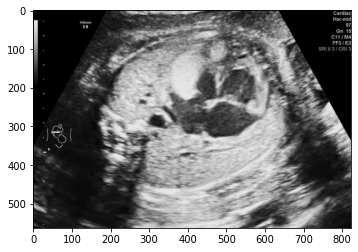

In [69]:
img = np.array(Image.open(img_path).convert('RGB'))
plt.imshow(img)

In [65]:
img_path

'/data/cc/Data/CHD/detection/images/abnormal_0000.png'

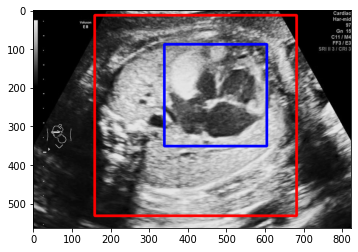

In [70]:
l = img[:]
l = cv2.rectangle(img=l, pt1=lung_pt1, pt2=lung_pt2, color=(255, 0, 0), thickness=5)
l = cv2.rectangle(img=l, pt1=heart_pt1, pt2=heart_pt2, color=(0, 0, 255), thickness=5)
plt.imshow(l)

In [73]:
result = Image.fromarray(l)
result.save(os.path.join(save_folder, img_name))